In [1]:
%cd ~/Workspace/kaggle-2019Q3-steel/

/home/chengjiun/Workspace/kaggle-2019Q3-steel


In [2]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, 
                            VerticalFlip, Normalize, Resize, Compose, GaussNoise)
from albumentations.torch import ToTensor
warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
# Set seed fol all
def seed_everything(seed=1358):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

# Dataloader

In [4]:
from pathlib import Path
DATA_BASE_PATH = Path('../DATA/kaggle-2019Q3-steel/') 
sample_submission_path = str(DATA_BASE_PATH / 'sample_submission.csv')
train_df_path = str(DATA_BASE_PATH / 'train.csv')
data_folder = str(DATA_BASE_PATH)
test_data_folder = str(DATA_BASE_PATH / "test_images")

In [5]:
from preprocess.dataloader import prepare_class_df, IMAGE_STATS_GLOBAL1, IMAGE_STATS_GLOBAL2

In [8]:
image_df = prepare_class_df(train_df_path, valid_ratio=0.1, upsample=False)


select defect types ['1', '2', '3', '4']
images included in the df: 12568 from 12568
images with defect 6666, ratio 0.5303946530872056
run split sample with 0.1, upsample: False
train / valid ratio: 0.10001591343093572
train defect ratio: 0.5303686676686411
valid defect ratio: 0.5306284805091488


# fastai implementation

In [9]:
from fastai.vision import get_transforms, ImageList, FloatList
from fastai.vision import cnn_learner, Learner
from optim.ranger import Ranger
from fastai.core import partial
from fastai.metrics import accuracy_thresh, accuracy
optar = partial(Ranger)

In [25]:
CV=1
seed = CV
bs = 20
tfms = get_transforms(flip_vert=True, do_flip=True, max_zoom=1.05, max_lighting=0.2, 
                      max_warp=0.05, max_rotate=5.)
data = (ImageList.from_df(df=image_df,path=DATA_BASE_PATH / 'train_images',cols='ImageId') 
        .split_from_df() 
        .label_from_df(cols='Detected',label_cls=FloatList) 
        .transform(tfms) 
        .databunch(bs=bs,num_workers=4) 
        .normalize(IMAGE_STATS_GLOBAL2)  
       )


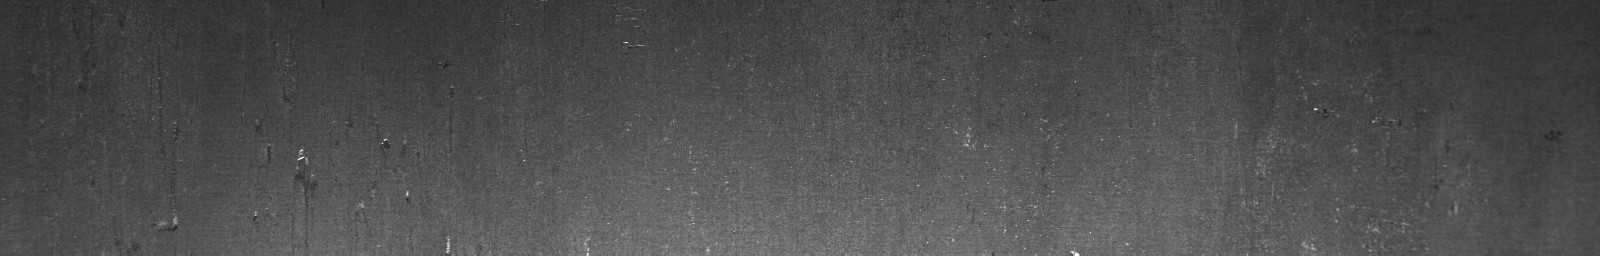

In [21]:
data.get(5)

In [13]:
data.get(5).shape

torch.Size([3, 256, 1600])

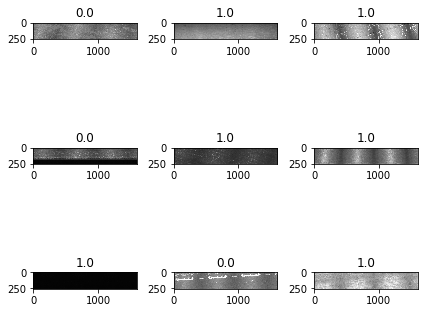

In [13]:

data.show_batch(3, row=bs, figsize=(6,6), hide_axis=False)

# model

In [22]:
from models.efficientnet import EfficientNet
#making model
arch = 'efficientnet-b0'
model_name = f'{arch}-v1'
# Parameters for the entire model (stem, all blocks, and head)

md_ef = EfficientNet.from_pretrained(arch, num_classes=1, dropout_rate=0.5)

In [26]:
learn = Learner(data, md_ef, opt_func=optar,
                metrics = [accuracy_thresh], 
                model_dir='fastai-class1').to_fp16()
learn.path = Path(DATA_BASE_PATH)

In [35]:
learn.model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.63E-02


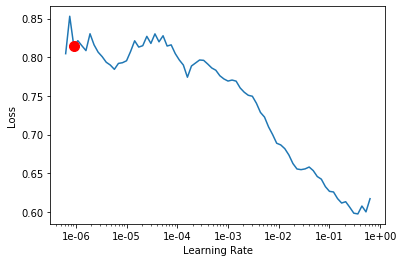

In [24]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
# First
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=1e-2)
learn.save(f'{model_name}')

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.234442,0.293014,0.530629,06:04
1,0.194230,0.198641,0.530469,06:07
2,0.173406,0.222889,0.530629,06:08


In [ ]:
# First
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=1e-3)
learn.save(f'{model_name}-stage2')

In [ ]:
# First
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=1e-3)
learn.save(f'{model_name}-stage3')